### Importing libraries

In [19]:
import numpy as np
import pandas as pd
import nltk
import lightgbm as lgb
import xgboost as xgb
import sklearn
import keras
from scipy.sparse import hstack
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Importing perticular things from these libraries

In [47]:
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

### Taking the data

In [3]:
data_df = pd.read_csv('FakeNewsDataset.csv')

### Taking a look at the data

In [4]:
data_df.head()

,Unnamed: 0,title,content,publication,label
0,0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28711 entries, 0 to 28710
Data columns (total 5 columns):
Unnamed: 0     28711 non-null int64
title          28031 non-null object
content        28665 non-null object
publication    28711 non-null object
label          28711 non-null object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


## Cleaning

1.We can infer from the publication name but it would not scale as ones who make fake news can also make real publication firm name

2.Inference can be taken from both title and content as title can be eye catching and attractive but content can be equally harmfull

### Step 1

In [7]:
new_data = data_df.copy()

In [9]:
new_data = new_data.drop(['Unnamed: 0','publication'],axis=1)

In [10]:
new_data.head()

,title,content,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,fake


3. We can also see that there are so many places or columns where tilte is null so we can fill them with null or unknown values

In [11]:
new_data = new_data.fillna("Unknown")

In [12]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28711 entries, 0 to 28710
Data columns (total 3 columns):
title      28711 non-null object
content    28711 non-null object
label      28711 non-null object
dtypes: object(3)
memory usage: 673.0+ KB


4. As the title and content of the article are in the same page as title can be in the first place and after it content come so we can combine them and then treat it as a single colum

In [14]:
new_data["news"] = new_data["title"]+" "+new_data["content"]

In [15]:
new_data = new_data.drop(["title","content"],axis=1)

In [16]:
new_data.head()

,label,news
0,fake,Muslims BUSTED: They Stole Millions In Gov’t B...
1,fake,Re: Why Did Attorney General Loretta Lynch Ple...
2,fake,BREAKING: Weiner Cooperating With FBI On Hilla...
3,fake,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...
4,fake,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...


In [17]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28711 entries, 0 to 28710
Data columns (total 2 columns):
label    28711 non-null object
news     28711 non-null object
dtypes: object(2)
memory usage: 448.7+ KB


This kind of data cleaning show us that it significantly reduced the data size as at the start data was about 140Mb now it very less compared to that and takes less memory spaces it will also easily fit in the ram

## Analysis

### Step 2

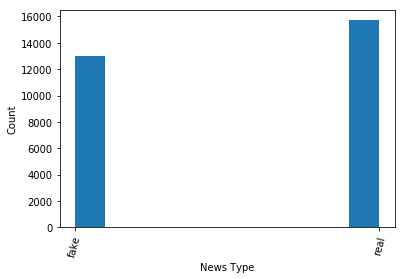

In [20]:
def plot_frequency(data):
    plt.hist([data["label"]])
    plt.xlabel("News Type")
    plt.ylabel("Count")
    plt.xticks(rotation=75)
    plt.show()
plot_frequency(new_data)

For doing some analysis we can clean our text data so we can get a clear picture afterwards

In [21]:
def cleaning(s):
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s
def data_clean(data,col_name):
    data[col_name] = data[col_name].apply(cleaning)
    return data

In [23]:
new_data = data_clean(new_data,"news")

Further we can lamatize the data to remove extra info and it is better then stemming as it keeps some of the info not deleating all

In [26]:
def lamatize(data):
    lematizer = WordNetLemmatizer()
    word = lematizer.lemmatize(data)
    return word
def applylam(data,col_name):
    data[col_name] = data[col_name].apply(lamatize)
    return data

In [27]:
new_data = applylam(new_data,"news")

#### we can see the canges in the data before and after wards

In [29]:
new_data.news[0]

'muslims busted they stole millions in gov t benefits print they should pay all the back all the money plus interest the entire family and everyone who came in with them need to be deported asap why did it take two years to bust them here we go again another group stealing from the government and taxpayers a group of somalis stole over four million in government benefits over just months we ve reported on numerous cases like this one where the muslim refugees immigrants mmit fraud by scamming our system it s way out of ntrol more related'

In [31]:
data_df.title[0] + " " + data_df.content[0]

'Muslims BUSTED: They Stole Millions In Gov’t Benefits Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related'

We can see significant complexity deceremnt which is done in text cleaning we can analyize the data easily

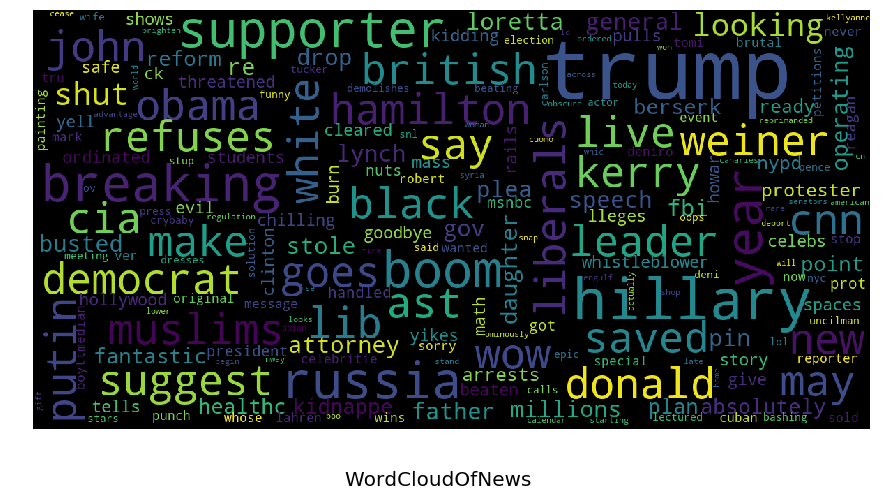

In [33]:
stopwords = set(STOPWORDS)
def wordCloud(data,title=None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordCloud(new_data["news"],"WordCloudOfNews")

### As we are anlyzing american fake news we can't find much difference or extra absurd term in word cloud but we tray to analyze fake and real news seperatly

In [39]:
fake = new_data[new_data["label"]=="fake"]
real = new_data[new_data["label"]=="real"]

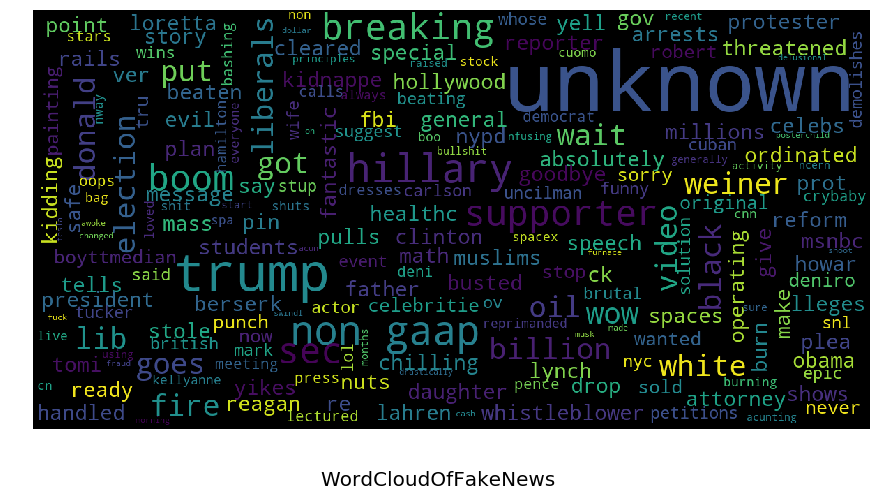

In [43]:
wordCloud(fake["news"],"WordCloudOfFakeNews")

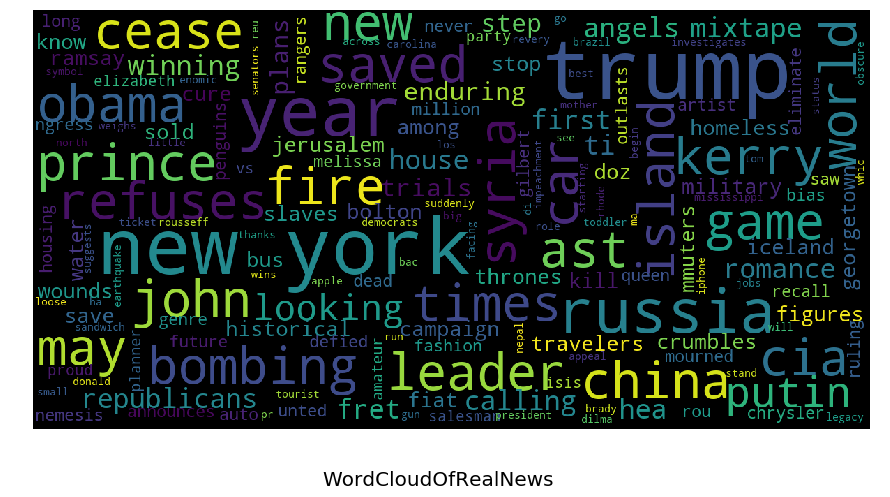

In [45]:
wordCloud(real["news"],"WordCloudOfRealNews")

### We can cluster the data so we can find the groups and see that the vectorizer is working properly or not

In [ ]:
#dividing data into cluster
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
model = vectorizer.fit_transform(new_data['news'].str.upper())
km = KMeans(n_clusters=10,init='k-means++',max_iter=200,n_init=1)
k=km.fit(model)
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:,::-1]
for i in range(10):
    print("cluster of words %d:" %i)
    #to print the first 10 words
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind])
    print()